In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import process_time
from mpmath import besseljzero
from scipy.special import gamma
from scipy.special import jv, iv
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

In [2]:
def k(a, da, t, q, sigma=2):
    return 0.5 * (q - 0.5*sigma - da(t))

def psi(a, da, t, z, tau, q, sigma=2):
    kk = k(a, da, t, q, sigma)
    
    if 2*np.sqrt(a(t)*z)/(sigma*(t-tau))<=700:
        term1 = 1./(sigma*(t - tau)) * np.exp(- (a(t) + z)/(sigma*(t-tau)))
        term2 = (a(t)/z)**(0.5*(q-sigma)/sigma)
        term3 = da(t) - (a(t)/(t-tau)) + kk
        term4 = iv(q/sigma-1, 2*np.sqrt(a(t)*z)/(sigma*(t-tau)))
        term5 = (np.sqrt(a(t)*z)/(t-tau)) * iv(q/sigma, 2*np.sqrt(a(t)*z)/(sigma*(t-tau)))
    else:
        term1 = 1./(sigma*(t - tau))
        term2 = (a(t)/z)**(0.5*(q-sigma)/sigma)
        term3 = da(t) - (a(t)/(t-tau)) + kk
        term4 = ive(q/sigma-1, (a(t) + z)/(sigma*(t-tau)))
        term5 = (np.sqrt(a(t)*z)/(t-tau)) * ive(q/sigma, (a(t) + z)/(sigma*(t-tau)))
    
    return term1 * term2 * (term3 * term4 + term5)

def ie_bessel_fpt(a, da, q, z, sigma=2, dt=0.1, T_max=2):
    g = [0]
    T = [0]
    g.append(-2*psi(a, da, dt, z, 0, q, sigma))
    T.append(dt)
    
    for n in range(2, int(T_max/dt)+2):
        s = -2 * psi(a, da, n*dt, z, 0, q, sigma)

        for j in range(1, n):
            s += 2 * dt * g[j] * psi(a, da, n*dt, a(j*dt), j*dt, q, sigma)

        g.append(s)
        T.append(n*dt)
        
    g = np.asarray(g)
    T = np.asarray(T)
    
    gt = interp1d(T, g)
    return gt

In [3]:
def series_bessel_fpt(t, a=1, sigma=1, nu=0, n=100):
    zeros = np.asarray([float(besseljzero(nu, i+1)) for i in range(n)])
    fpt = np.zeros(t.shape)
    
    for i in range(t.shape[0]):
        series = np.sum((zeros**(nu+1)/jv(nu+1, zeros)) * np.exp(-(zeros**2 * sigma**2)/(2*a**2)*t[i]))
        fpt[i] = sigma**2/(2**nu * a**2 * gamma(nu + 1)) * series
        
    return interp1d(t, fpt)

In [4]:
def cal_time_series(dim, rep=20):
    series_comp_time = {'25':[],
                        '50':[],
                        '75':[],
                        '100':[]}
    
    for N in [25, 50, 75, 100]:
        for _ in range(rep):
            time_start = process_time()
            series_bessel_fpt(np.arange(0.001, 5, 0.1), a=2, sigma=1, nu=(dim-2)/2, n=N)
            time_elapsed = (process_time() - time_start)
            series_comp_time[str(N)].append(time_elapsed)

    return pd.DataFrame(series_comp_time)
    

In [5]:
def cal_time_ie(dim, rep=20):
    ie_comp_time = {'0.2':[],
                    '0.15':[],
                    '0.1':[],
                    '0.05':[]}
    
    for dt in [0.2, 0.15, 0.1, 0.05]:
        for _ in range(rep):
            time_start = process_time()
            ie_bessel_fpt(lambda t: 4, lambda t:0, dim, 0.0001, sigma=2, dt=dt, T_max=5)
            time_elapsed = (process_time() - time_start)
            ie_comp_time[str(dt)].append(time_elapsed)

    return pd.DataFrame(ie_comp_time)

# Computational time

In [6]:
series_comp_time_2D = cal_time_series(2, rep=50)
series_comp_time_3D = cal_time_series(3, rep=50)
series_comp_time_4D = cal_time_series(4, rep=50)

In [7]:
ie_comp_time_2D = cal_time_ie(2, rep=50)
ie_comp_time_3D = cal_time_ie(3, rep=50)
ie_comp_time_4D = cal_time_ie(4, rep=50)

# plot

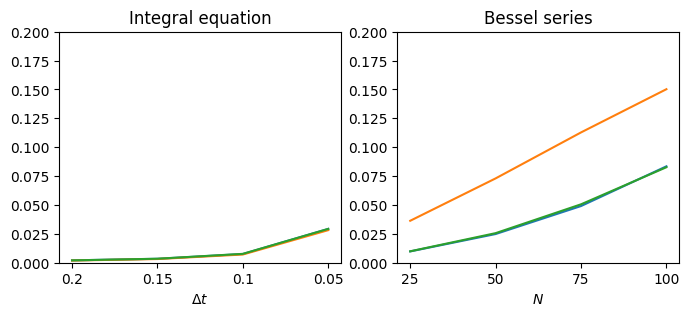

In [18]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.ylim(0, 0.2)
plt.plot(ie_comp_time_2D.mean().index,
         ie_comp_time_2D.mean().values)
plt.plot(ie_comp_time_3D.mean().index,
         ie_comp_time_3D.mean().values)
plt.plot(ie_comp_time_4D.mean().index,
         ie_comp_time_4D.mean().values)
plt.title('Integral equation')
plt.xlabel(r'$\Delta t$')

plt.subplot(122)
plt.ylim(0, 0.2)
plt.plot(series_comp_time_2D.mean().index,
         series_comp_time_2D.mean().values)
plt.plot(series_comp_time_3D.mean().index,
         series_comp_time_3D.mean().values)
plt.plot(series_comp_time_4D.mean().index,
         series_comp_time_4D.mean().values);
plt.title('Bessel series')
plt.xlabel(r'$N$');